## 进入 MMPose 主目录

In [1]:
import os
os.chdir('mmpose')
os.listdir()

['.git',
 '.circleci',
 '.dev_scripts',
 '.github',
 '.gitignore',
 '.pre-commit-config.yaml',
 '.pylintrc',
 '.readthedocs.yml',
 'CITATION.cff',
 'LICENSE',
 'MANIFEST.in',
 'README.md',
 'README_CN.md',
 'configs',
 'demo',
 'docker',
 'docs',
 'mmpose',
 'model-index.yml',
 'pytest.ini',
 'requirements.txt',
 'requirements',
 'resources',
 'setup.cfg',
 'setup.py',
 'tests',
 'tools',
 'mmpose.egg-info',
 'checkpoints',
 'outputs',
 'data',
 'hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth',
 'td-hm_hrnet-w48_8xb32-210e_coco-256x192.py',
 'vis_results.jpg']

## 指定模型`config`配置文件和`checkpoint`权重文件

In [2]:
# 目标检测模型
det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 人体姿态估计模型
pose_config = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w48_8xb32-210e_coco-256x192.py'
pose_checkpoint = 'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth'

## 导入工具包

In [3]:
import mmcv
from mmcv import imread
import mmengine
import numpy as np

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples
from mmpose.utils import register_all_modules as register_mmpose_modules

try:
    from mmdet.apis import inference_detector, init_detector
    from mmdet.utils import register_all_modules as register_mmdet_modules
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False

local_runtime = False

try:
    from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
    local_runtime = True

img = 'tests/data/coco/000000197388.jpg'

cfg_options = dict(model=dict(test_cfg=dict(output_heatmaps=True)))

## 初始化模型

In [4]:
# 目标检测模型
register_mmdet_modules()
detector = init_detector(
    det_config,
    det_checkpoint,
)


# 人体姿态估计模型
register_mmpose_modules()
pose_estimator = init_pose_estimator(
    pose_config,
    pose_checkpoint,
    cfg_options=cfg_options
)

02/01 16:05:52 - mmengine - WARNING - The "model" registry in mmdet did not set import location. Fallback to call `mmdet.utils.register_all_modules` instead.
02/01 16:05:52 - mmengine - WARNING - The "task util" registry in mmdet did not set import location. Fallback to call `mmdet.utils.register_all_modules` instead.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
02/01 16:06:01 - mmengine - WARNING - The "model" registry in mmpose did not set import location. Fallback to call `mmpose.utils.register_all_modules` instead.
02/01 16:06:01 - mmengine - WARNING - The "KEYPOINT_CODECS" registry in mmpose did not set import location. Fallback to call `mmpose.utils.register_all_modules` instead.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth
02/01 16:06:02 - mmengine 

In [5]:
# 初始化可视化工具
pose_estimator.cfg.visualizer.radius = 3
pose_estimator.cfg.visualizer.line_width = 1
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

02/01 16:06:02 - mmengine - WARNING - The "visualizer" registry in mmpose did not set import location. Fallback to call `mmpose.utils.register_all_modules` instead.


/environment/miniconda3/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:163: UserWarning: `Visualizer` backend is not initialized because save_dir is None.
  warnings.warn('`Visualizer` backend is not initialized '


## 可视化一张图的预测关键点和热图

In [6]:
def visualize_img(img_path, detector, pose_estimator, visualizer,
                  show_interval, out_file):

    # 预测框
    register_mmdet_modules()
    detect_result = inference_detector(detector, img_path)
    pred_instance = detect_result.pred_instances.cpu().numpy()
    bboxes = np.concatenate(
        (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
    bboxes = bboxes[np.logical_and(pred_instance.labels == 0,
                                   pred_instance.scores > 0.3)]
    bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

    # 预测关键点
    register_mmpose_modules()
    pose_results = inference_topdown(pose_estimator, img_path, bboxes)
    data_samples = merge_data_samples(pose_results)

    # 输出结果
    img = mmcv.imread(img_path)
    img = mmcv.imconvert(img, 'bgr', 'rgb')

    visualizer.add_datasample(
        'result',
        img,
        data_sample=data_samples,
        draw_gt=False,
        draw_heatmap=True,
        draw_bbox=True,
        show=False,
        wait_time=show_interval,
        out_file=out_file,
        kpt_score_thr=0.3)

In [7]:
visualize_img(
    img,
    detector,
    pose_estimator,
    visualizer,
    show_interval=0,
    out_file=None)

vis_result = visualizer.get_image()

02/01 16:06:14 - mmengine - WARNING - The "transform" registry in mmdet did not set import location. Fallback to call `mmdet.utils.register_all_modules` instead.
02/01 16:06:14 - mmengine - WARNING - The "transform" registry in mmpose did not set import location. Fallback to call `mmpose.utils.register_all_modules` instead.


/environment/miniconda3/lib/python3.7/site-packages/mmdet/utils/setup_env.py:83: UserWarning: The current default scope "mmpose" is not "mmdet", `register_all_modules` will force the currentdefault scope to be "mmdet". If this is not expected, please set `init_default_scope=False`.
  warnings.warn('The current default scope '
/home/featurize/work/7/mmpose/mmpose/utils/setup_env.py:79: UserWarning: The current default scope "mmdet" is not "mmpose", `register_all_modules` will force the currentdefault scope to be "mmpose". If this is not expected, please set `init_default_scope=False`.
  warnings.warn('The current default scope '
/environment/miniconda3/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:632: UserWarning: Warning: The circle is out of bounds, the drawn circle may not be in the image
  ' the drawn circle may not be in the image', UserWarning)
/environment/miniconda3/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:709: UserWarning: Warning: Th

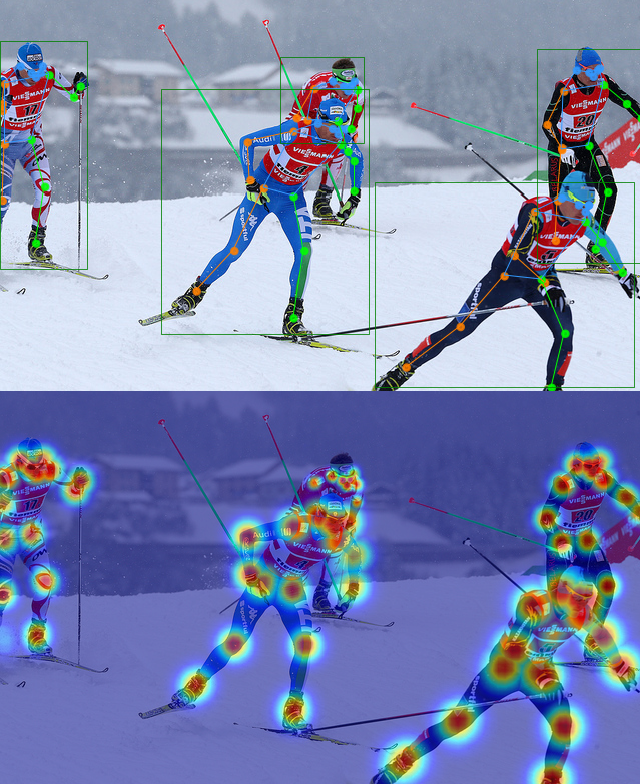

In [8]:
if local_runtime:
    from IPython.display import Image, display
    import tempfile
    import os.path as osp
    import cv2
    with tempfile.TemporaryDirectory() as tmpdir:
        file_name = osp.join(tmpdir, 'pose_results.png')
        cv2.imwrite(file_name, vis_result[:,:,::-1])
        display(Image(file_name))
else:
    cv2_imshow(vis_result)